## Task 2 : Reconstructing using Random Fourier Features (RFF) [3 marks]

In [ ]:
# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')
#import modules
import torch
from torchvision.io import read_image
import torchvision.transforms.v2 as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
from sklearn import preprocessing
import torch.nn as nn
import torch.nn.functional as F

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

### 1) Image Reconstruction
Choose any image you like. Use Random Fourier Features (RFF) and Linear Regression to learn the mapping from the image coordinates (X,Y) to the pixel colors (R,G,B). Here, (X,Y) represents the coordinates of the pixels, and (R,G,B) represents the color values at those coordinates. Display both the original image and the reconstructed image. Also, calculate and report the Root Mean Squared Error (MSE) and Peak Signal-to-Noise Ratio (PSNR) between the original and reconstructed images. *[1.5 Mark]*

In [ ]:
# utility functions
def show_one_img(img: torch.Tensor):
    """Show one image."""
    plt.imshow(img)
    plt.axis('off')
    plt.show()

> Loading and reshaping image

The order of the tensor from `read_image` is often referred to as `CHW` __(Color Channels, Height, Width)__.

There's debate on whether images should be represented as `CHW` __(color channels first)__ or `HWC` __(color channels last)__.

PyTorch generally accepts `NCHW` (channels first) as the default for many operators.

*However, PyTorch also explains that `NHWC` __(channels last)__ performs better and is considered best practice. So, we change the order to `HWC` using `permute`*

torch.Size([1365, 2048, 3])


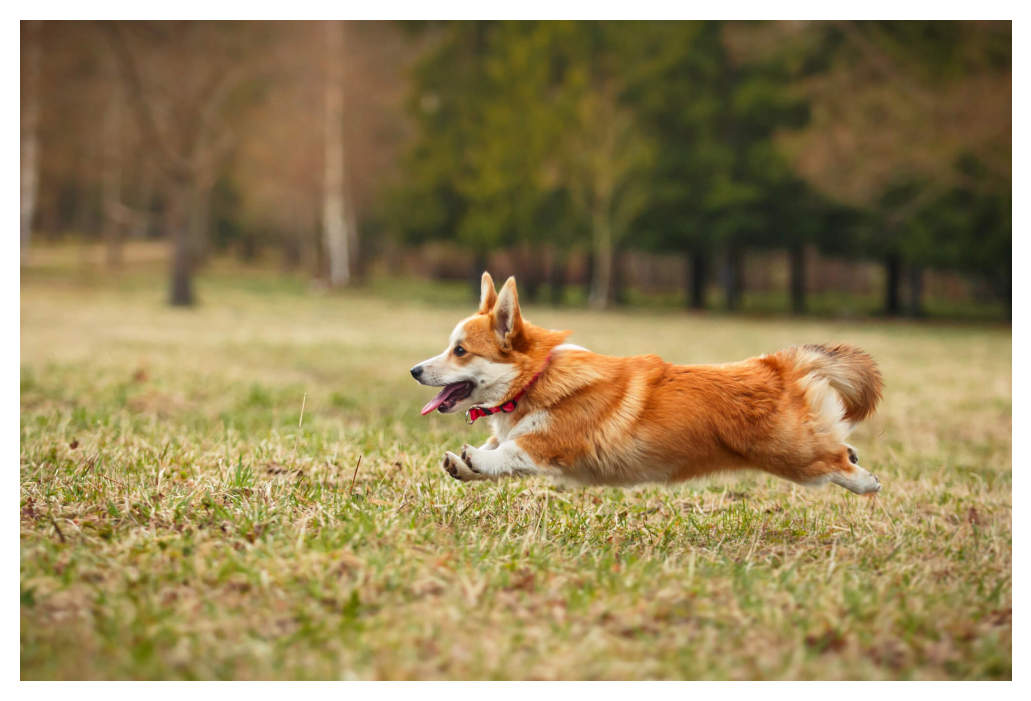

In [ ]:
filename = "dog.jpg"
img = read_image(filename).permute(1, 2, 0)
print(img.shape)
show_one_img(img)

> Scaling pixel values to between 0 and 1

In [ ]:
scaler = preprocessing.MinMaxScaler()
scaled_img_numpy = scaler.fit_transform(img.reshape(-1, 1)).reshape(img.shape)
scaled_img = torch.tensor(scaled_img_numpy)
scaled_img[0, 0:5, :]                   # seeing some values

tensor([[0.3098, 0.2039, 0.1373],
        [0.3137, 0.2078, 0.1412],
        [0.3137, 0.2078, 0.1412],
        [0.3176, 0.2118, 0.1451],
        [0.3216, 0.2157, 0.1490]], dtype=torch.float64)

> cropping the image to get a smaller section of `300 x 300 pixels`

torch.Size([300, 300, 3])


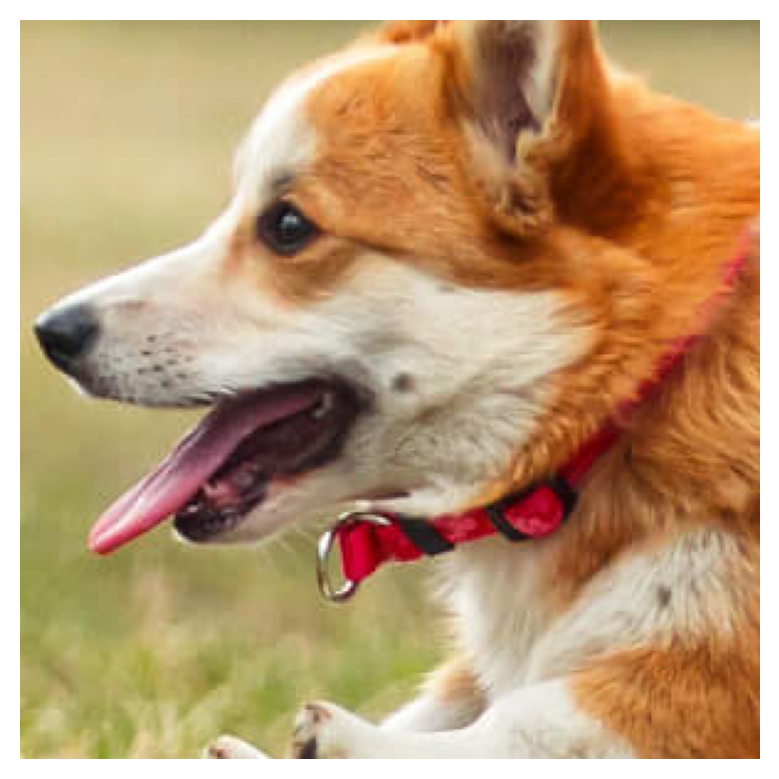

In [ ]:
cropped_img = transforms.functional.crop(scaled_img.permute(2, 0, 1), 600, 800, 300, 300).permute(1, 2, 0)    # since crop takes tensor in CHW format, we permute
print(cropped_img.shape)
show_one_img(cropped_img)

In [ ]:
#moving tensor to gpu
cropped_img = cropped_img.to(device)

> function to create a coordinate mapping for the image

In [ ]:
def create_coordinate_map(img: torch.Tensor)-> tuple[torch.Tensor, torch.Tensor]:
    """
    img shape: (height, width, num_channels)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """
    height, width, num_channels = img.shape
    
    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1)

    # Reshape image for mapping
    Y = img.reshape(-1, num_channels)
    return X, Y

In [ ]:
#getting coordinate mapping and scaling the coordinate values of the pixels
X_coords, Y_values = create_coordinate_map(cropped_img)
# MinMaxScaler from -1 to 1
X_coords_scaled = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit_transform(X_coords)
# converting to float32 tensor
X_coords_scaled = torch.tensor(X_coords_scaled, device=device).float()

> Making Linear model definition

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

> Training model  
> First, we'll train with just the original features for comparison

In [ ]:
model = LinearModel(X_coords_scaled.shape[1], Y_values.shape[1])
model.to(device)

LinearModel(
  (linear): Linear(in_features=2, out_features=3, bias=True)
)

In [ ]:
def train(net: nn.Module, lr: float, X:torch.Tensor, Y:torch.Tensor, epochs: int, verbose=True)->float:
    """
    net: torch.nn.Module  
    lr: float  
    X: torch.Tensor of shape (num_samples, 2)  
    Y: torch.Tensor of shape (num_samples, 3)  
    returns:  
    final MSE loss value after training
    """
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    Y = Y.float()

    for epoch in range(epochs+1):
        optimizer.zero_grad()
        outputs = net(X)
        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()

        if verbose and epoch % 500 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")

    return loss.item()

In [ ]:
train(model, 0.01, X_coords_scaled, Y_values, 1000)

Epoch 0 loss: 0.036823
Epoch 500 loss: 0.036823
Epoch 1000 loss: 0.036823


0.03682255372405052

> function to display origianal and reconstructed image

In [ ]:
def plot_original_and_recon_image(original_img: torch.Tensor, net: nn.Module, X: torch.Tensor, title="") -> torch.Tensor:
    """
    original_img: image with which reconstruction is to be compared  
    net: torch.nn.Module  
    X: torch.Tensor of shape (num_samples, 2)  
    returns:  
    reconstructed image tensor
    """
    height, width, num_channels = original_img.shape
    net.eval()
    with torch.inference_mode():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")

    ax1.imshow(original_img.cpu())
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")

    fig.suptitle(title, y=0.9)
    plt.tight_layout()
    return outputs.cpu()

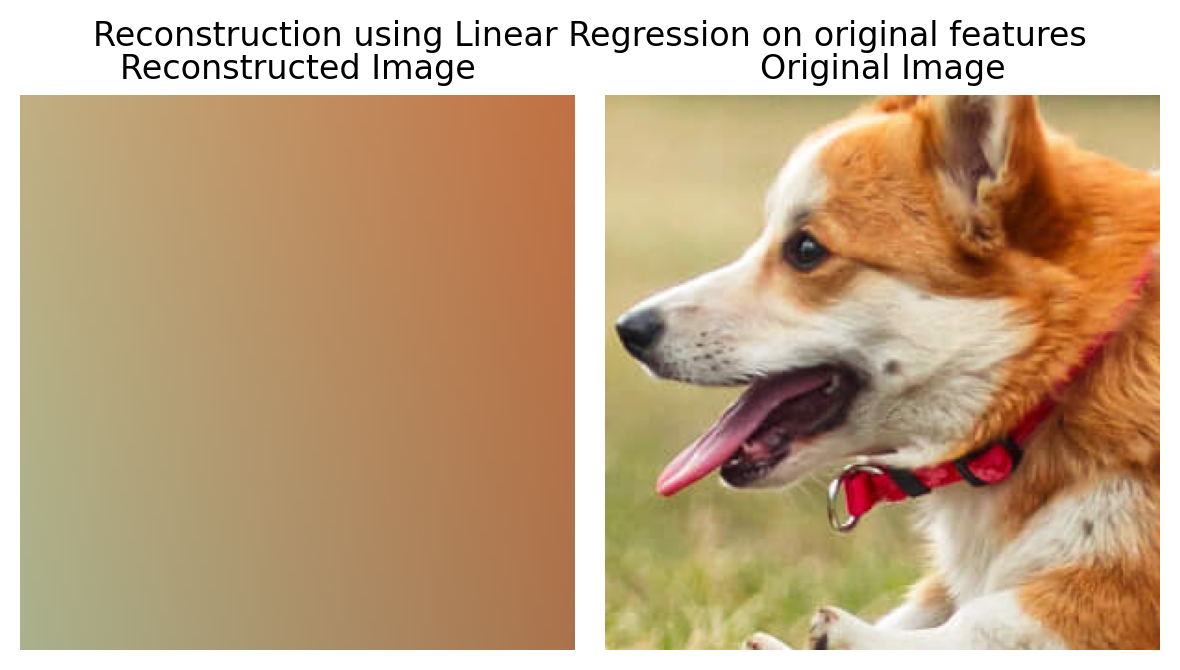

In [ ]:
og_recon_img = plot_original_and_recon_image(cropped_img, model, X_coords_scaled, title="Reconstruction using Linear Regression on original features")

> Now, training with Radial basis function sampling on Random Fourier features (RFF)

In [ ]:
# tracking loss and psnr values for each experiment
metrics_rffs = {}
images_rffs = {}

In [ ]:
# function to create RFF features
def create_rff_features(X:torch.Tensor, num_features: int, sigma: float):
    """
    creates feature space using Radial basis function on Random fourier features on the tensor X  
    X (torch.Tensor): input tensor  
    num_features: number of features to generate  
    sigma: sigma to calculate gamma of RBF kernel   
    """
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2))
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

> Function for the whole pipeline and displaying the reconstructed image with RFF features model

In [ ]:
# function to train model, reconstruct image and calculate errors.
def reconstruct_with_rff(X: torch.Tensor, Y: torch.Tensor, num_rff) -> tuple[float, torch.Tensor]:
    """
    Reconstructs an image using the Radial Frequency Features (RFF) of the input tensor X.  
    """
    epochs = 2500
    X_coords_rff = create_rff_features(X, num_rff, 0.008)

    # initialize model
    rff_model = LinearModel(X_coords_rff.shape[1], Y.shape[1])
    rff_model.to(device)

    # train model and get final loss after training
    loss = train(rff_model, 0.005, X_coords_rff, Y, epochs)
    
    # show img as well as get the generated image to return it
    img = plot_original_and_recon_image(cropped_img, rff_model, X_coords_rff, title=f"Reconstruction using Linear Regression on RFF ({num_rff} features)")

    return loss, img


> Training with 1000 RFFs

Epoch 0 loss: 0.377928
Epoch 500 loss: 0.036605
Epoch 1000 loss: 0.036602
Epoch 1500 loss: 0.036602
Epoch 2000 loss: 0.036602
Epoch 2500 loss: 0.036602


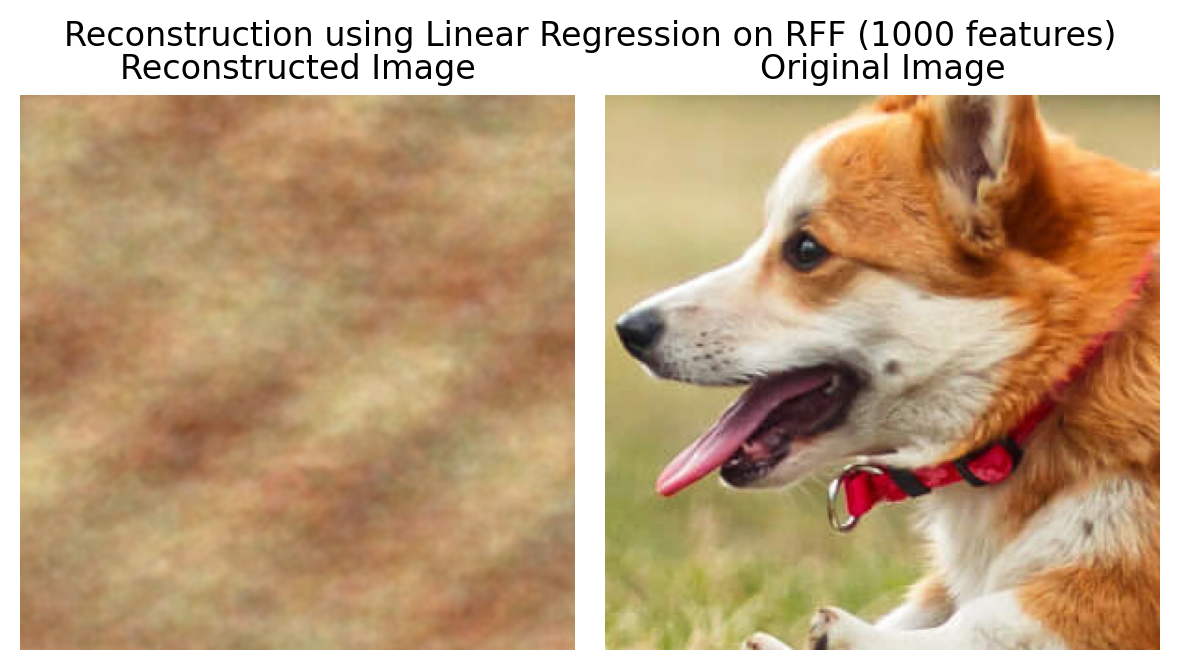

In [ ]:
num_rff_features = 1000
loss, img = reconstruct_with_rff(X_coords_scaled, Y_values,  num_rff_features)
metrics_rffs[num_rff_features] = {'loss':loss}
images_rffs[num_rff_features] = img

> Training with 5000 RFFs

Epoch 0 loss: 0.360322
Epoch 500 loss: 0.026822
Epoch 1000 loss: 0.025513
Epoch 1500 loss: 0.025081
Epoch 2000 loss: 0.024815


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 2500 loss: 0.024601


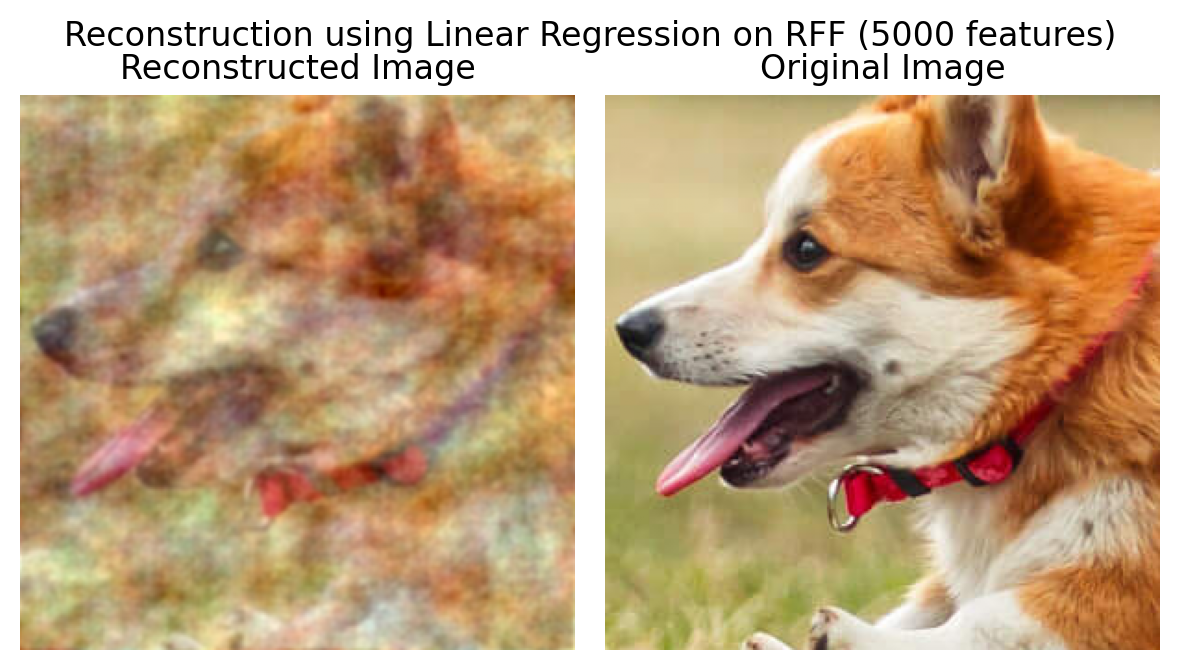

In [ ]:
num_rff_features = 5000
loss, img = reconstruct_with_rff(X_coords_scaled, Y_values,  num_rff_features)
metrics_rffs[num_rff_features] = {'loss':loss}
images_rffs[num_rff_features] = img

> Training with 15000 RFFs

In [ ]:
num_rff_features = 15000
loss, img = reconstruct_with_rff(X_coords_scaled, Y_values,  num_rff_features)
metrics_rffs[num_rff_features] = {'loss':loss}
images_rffs[num_rff_features] = img

In [ ]:
metrics_rffs, images_rffs

### *References*
- [Zero to Mastery Learn PyTorch](https://www.learnpytorch.io/)
- Video - [PyTorch for Deep Learning & Machine Learning](https://www.youtube.com/watch?v=V_xro1bcAuA)
- [Radial Basis Function Kernel](https://www.geeksforgeeks.org/radial-basis-function-kernel-machine-learning/)
- [TorchVision Object Detection Finetuning Tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html#torchvision-object-detection-finetuning-tutorial)
- [scikit-learn docs](https://scikit-learn.org/stable/api/index.html)